In [8]:
import torch
import torchvision
import torchmetrics
import cv2
import imgaug
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import pytorch_lightning as pl
from pathlib import Path
from tqdm.notebook import tqdm
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from celluloid import Camera
from IPython.display import HTML
from torchvision import transforms
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


In [3]:
root = Path('Task02_Heart/imagesTr/')
label = Path('Task02_Heart/labelsTr/')

In [4]:
def change_img_to_lbl_path(path):
    parts = list(path.parts)
    parts[parts.index('imagesTr')] = 'labelsTr'
    return Path(*parts)

In [5]:
sample_path = list(root.glob('la*'))[0]
sample_path_lbl = change_img_to_lbl_path(sample_path)
sample_path, sample_path_lbl

(PosixPath('Task02_Heart/imagesTr/la_022.nii.gz'),
 PosixPath('Task02_Heart/labelsTr/la_022.nii.gz'))

In [6]:
data = nib.load(sample_path)
label = nib.load(sample_path_lbl)


mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

nib.aff2axcodes(data.affine)

('R', 'A', 'S')

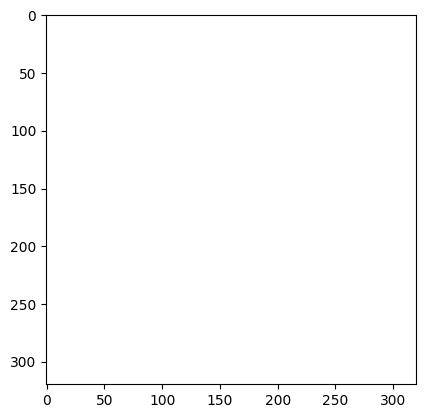

In [8]:
fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
    plt.imshow(mri[:,:,i], cmap="gray")
    mask_ = np.ma.masked_where(mask[:,:,i]==0 , mask[:,:,i])
    plt.imshow(mask_ , alpha = 0.6 , cmap="autumn")
    camera.snap()

animation = camera.animate()
HTML(animation.to_html5_video())

In [35]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu)/std
    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min())/(normalized.max()- normalized.min())
    return standardized

In [10]:
all_files= list(root.glob("la*"))
len(all_files)

20

  0%|          | 0/20 [00:00<?, ?it/s]

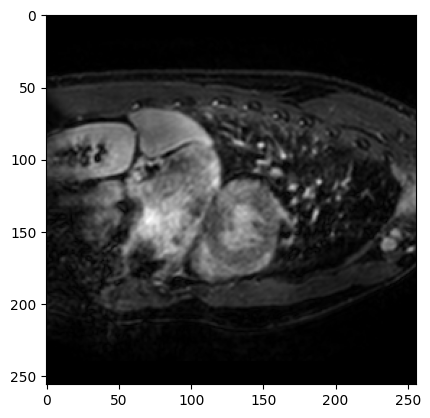

In [ ]:
save_root = Path("Preprocessed")


for counter , path_to_mri_data in enumerate(tqdm(all_files)):
    
    path_to_lbl = change_img_to_lbl_path(path_to_mri_data)

    mri = nib.load(path_to_mri_data)
    assert nib.aff2axcodes(mri.affine) == ('R', 'A', 'S')
    mri_data = mri.get_fdata()

    lbl = nib.load(path_to_lbl)
    lbl_data = lbl.get_fdata().astype(np.uint8)

    plt.imshow(mri_data[:,:,1], cmap='gray')
    mri_data = mri_data[32:-32,32:-32] #crop data around heart
    plt.imshow(mri_data[:,:,1], cmap='gray')
    
    lbl_data = lbl_data[32:-32,32:-32]#crop label around heart


    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)


    if counter < 17 :
        current_path = save_root/"train"/str(counter)
    else : 
        current_path = save_root/"val"/str(counter)


    for i in range(standardized_mri_data.shape[-1]):
        slice = standardized_mri_data[:,:,i]
        mask = lbl_data[:,:,i]

        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        
        slice_path.mkdir(parents=True ,exist_ok= True )
        mask_path.mkdir(parents=True ,exist_ok= True )


        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)

In [12]:
path= Path("Preprocessed/train/1")
file = '60.npy'
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

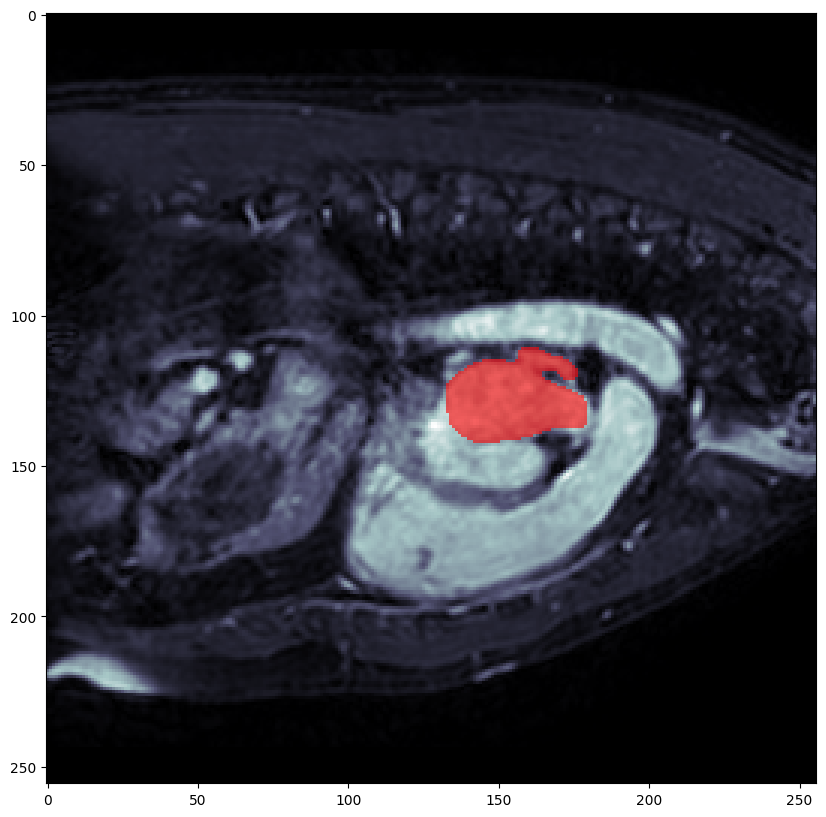

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(slice,cmap='bone')
mask_ = np.ma.masked_where(mask==0 , mask)
plt.imshow(mask_ , alpha = 0.6 , cmap='autumn')

In [12]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
    
    @staticmethod
    def extract_files(root):
        files = []
        for subject in root.glob("*"):   
            slice_path = subject/"data"
            for slice in slice_path.glob("*"):
                files.append(slice)
        return files
    
    
    @staticmethod
    def change_img_to_label_path(path):
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):

        random_seed = torch.randint(0, 1000000, (1,))[0].item()
        imgaug.seed(random_seed)
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug
    
    def __len__(self):
        return len(self.all_files)
 
    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        
        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)

In [13]:
seq = iaa.Sequential([iaa.Affine(scale=(0.85 , 1.15),rotate=(-45, 45)),iaa.ElasticTransformation()])

In [14]:
path = Path("Preprocessed/train/")
dataset = CardiacDataset(path , seq)

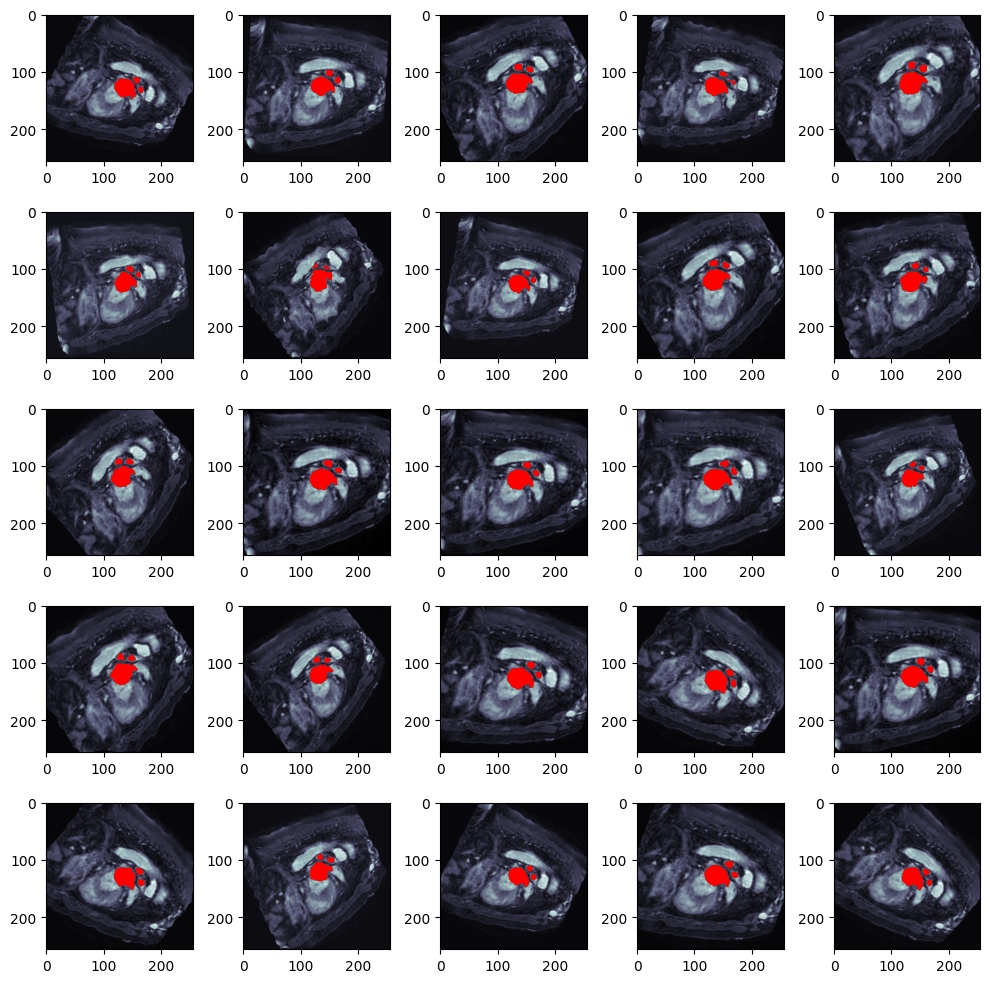

In [24]:
fig , ax = plt.subplots(5,5,figsize=(10,10))

for i in range(5):
    for j in range(5):
        slice , mask = dataset[66]
        mask_ = np.ma.masked_where(mask==0 , mask)
        ax[i][j].imshow(slice[0] , cmap="bone")
        ax[i][j].imshow(mask_[0] , cmap="autumn")
        # print(mask.max(), mask.min(), mask.sum())

plt.tight_layout()

In [9]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())
        
    def forward(self, X):
        return self.step(X)

In [10]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)
        
        self.layer5 = DoubleConv(512+256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)
        
        self.maxpool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        
        x4 = self.layer4(x3m)
        
        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)
        
        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)
        
        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        
        ret = self.layer8(x7)
        return ret

In [15]:
train_path = Path("Preprocessed/train/")
val_path = Path("Preprocessed/val")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

In [16]:
len(train_dataset)

1951

In [17]:
len(val_dataset)

320

In [18]:
batch_size = 8
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [19]:
class DiceLoss(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        counter = (pred * mask).sum()      
        denum = pred.sum() + mask.sum() + 1e-8  
        dice =  (2*counter)/denum
        return 1 - dice

In [20]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Dice", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Dice", loss)
        
        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")
            
        return loss
    
    def log_images(self, mri, pred, mask, name):
        
        pred = pred > 0.5
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        
        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)
        
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

torch.manual_seed(0)

model = AtriumSegmentation()

checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=10,
    mode='min'
)

trainer = pl.Trainer(
    accelerator="gpu",   
    devices=1,           
    logger=TensorBoardLogger(save_dir="./logs"),
    log_every_n_steps=1,
    callbacks=[checkpoint_callback],
    max_epochs=10
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [41]:
import warnings
warnings.filterwarnings("ignore")

In [42]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | UNet     | 7.8 M  | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [28]:
model = AtriumSegmentation.load_from_checkpoint("logs/lightning_logs/version_0/checkpoints/epoch=2-step=939.ckpt")

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

AtriumSegmentation(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2):

In [30]:
prediction = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)
    prediction.append(pred.cpu().numpy())
    labels.append(label)
    
prediction = np.array(prediction)
labels = np.array(labels)

  0%|          | 0/320 [00:00<?, ?it/s]

In [31]:
model.loss_fn(torch.from_numpy(prediction), torch.from_numpy(labels))

tensor(0.4077)

In [32]:
dice_score = 1-DiceLoss()(torch.from_numpy(prediction), torch.from_numpy(prediction).unsqueeze(0).float())
dice_score

tensor(0.9596)

In [33]:
subject = Path("Task02_Heart/imagesTs/la_008.nii.gz")
subject_mri = nib.load(subject).get_fdata()

In [36]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [37]:
standardized_scan.shape

(192, 192, 110)

In [38]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slices = standardized_scan[:, :, i]
    with torch.no_grad():
        pred = model(torch.tensor(slices).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

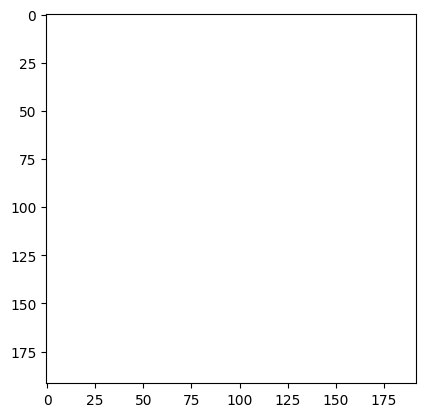

In [39]:
fig = plt.figure()
camera = Camera(fig)

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:, :, i], cmap="bone")
    mask = np.ma.masked_where(preds[i] == 0, preds[i])
    plt.imshow(mask, alpha=0.5)
    camera.snap()
animation = camera.animate()
from IPython.display import HTML
HTML(animation.to_html5_video())